#**Task 1**

###**1. Image Inpainting (Noise Removal)**

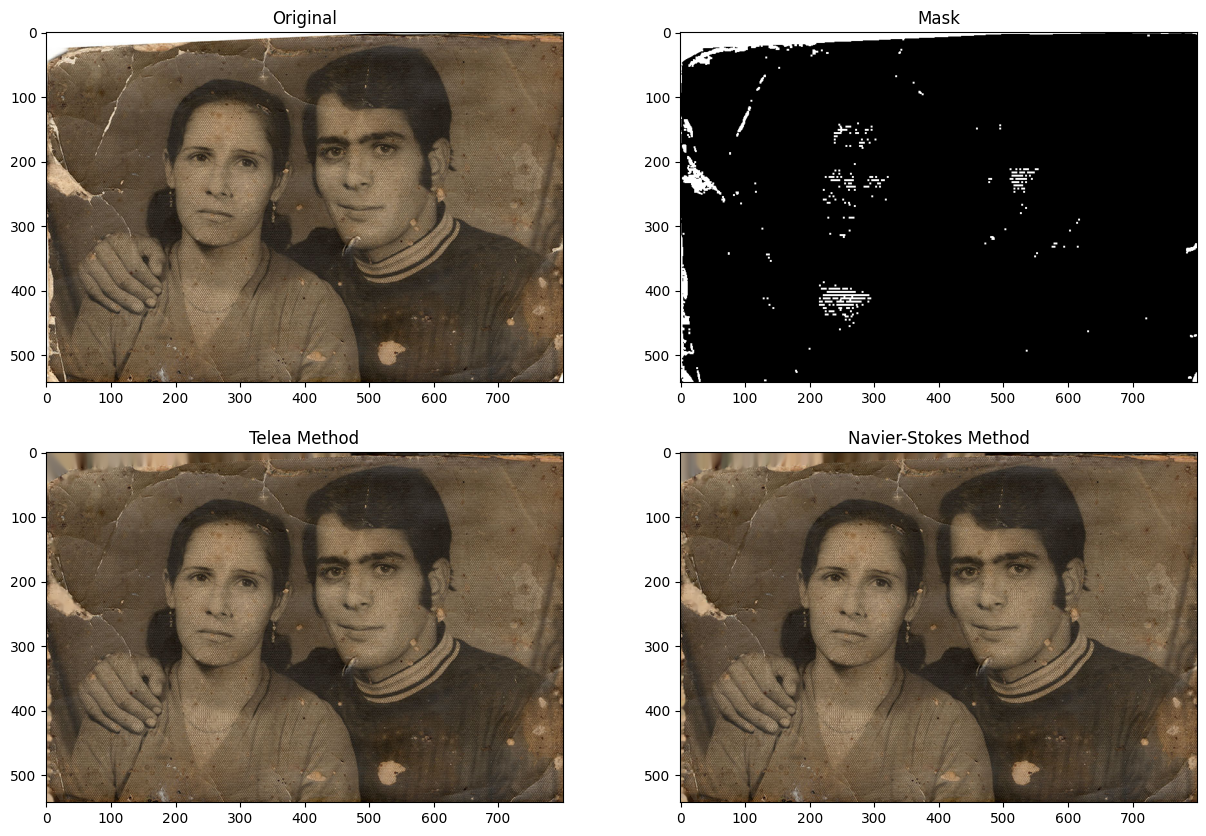

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the damaged image
image = cv2.imread('/content/Damaged.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a mask where white represents the damaged areas
# (You'll need to adjust this based on your specific image)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray, 195, 255, cv2.THRESH_BINARY)

# Dilate the mask to cover more area around the scratches
kernel = np.ones((3,3), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)

# Apply inpainting
result_telea = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
result_ns = cv2.inpaint(image, mask, 3, cv2.INPAINT_NS)

# Display results
plt.figure(figsize=(15,10))
plt.subplot(221), plt.imshow(image), plt.title('Original')
plt.subplot(222), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.subplot(223), plt.imshow(result_telea), plt.title('Telea Method')
plt.subplot(224), plt.imshow(result_ns), plt.title('Navier-Stokes Method')
plt.show()

###**2. Image Stitching/Panorama**

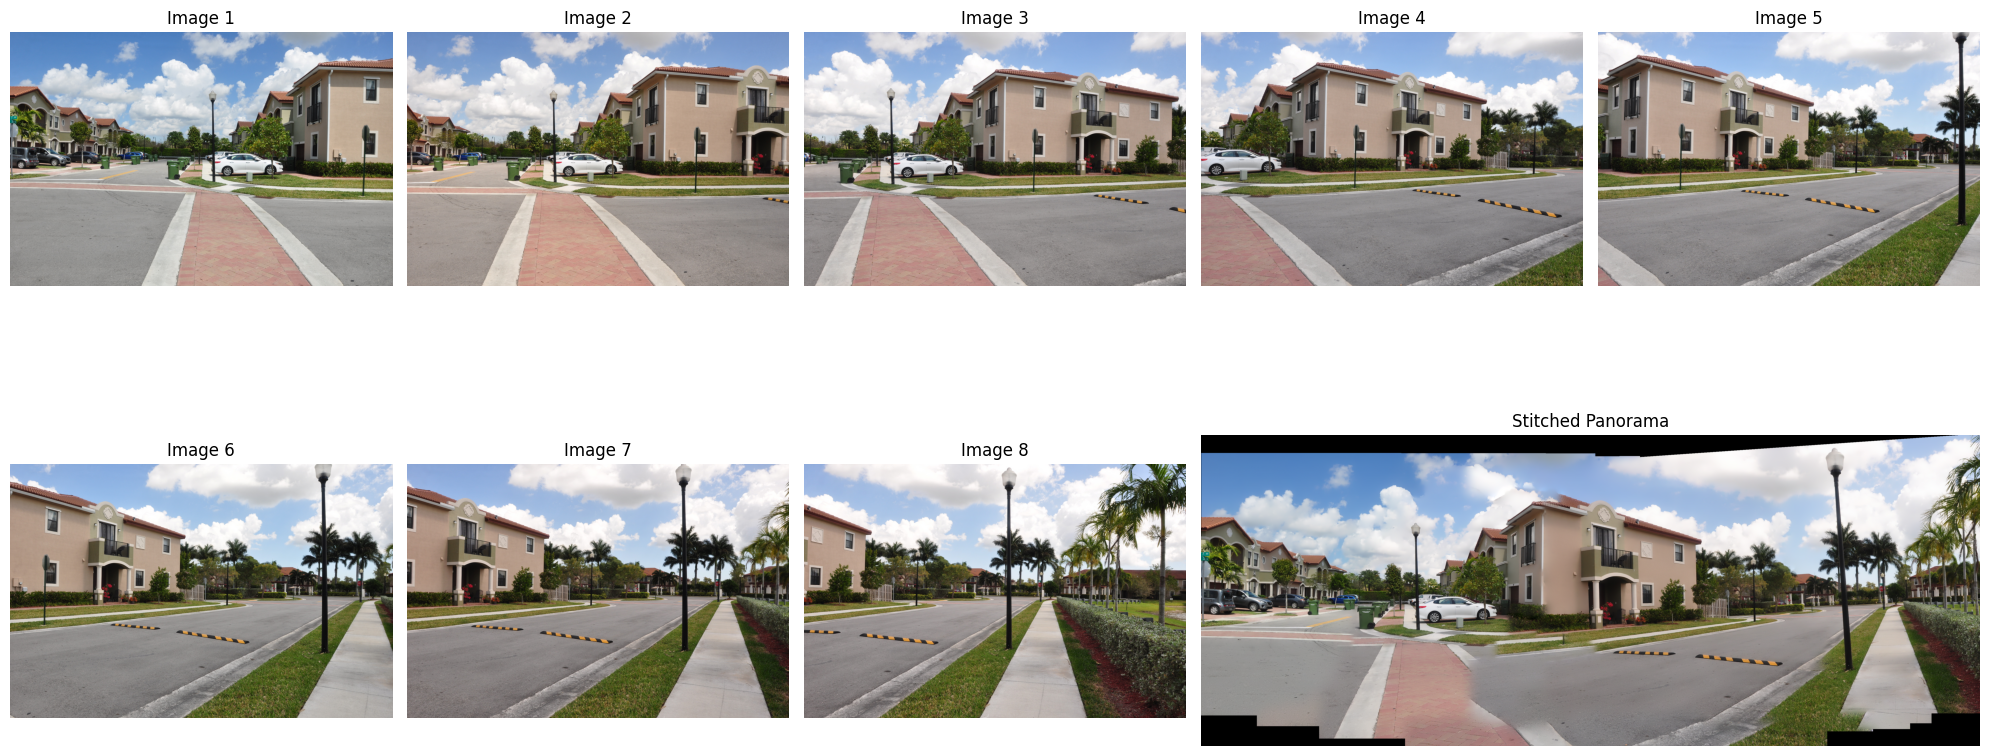

Panorama saved as panorama_result.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load all 8 images
images = []
images_rgb = []

for i in range(1, 9):
    img = cv2.imread(f'00{i}.jpg')
    if img is None:
        print(f"Error: Could not load image overlap{i}.jpg")
        exit()
    images.append(img)
    images_rgb.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Initialize OpenCV's stitcher with higher confidence threshold
stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)  # Use SCANS mode for more images
stitcher.setPanoConfidenceThresh(0.5)  # Lower threshold to handle more images

# Try stitching with different subsets if full set fails
status, stitched = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    # Convert to RGB for display
    stitched_rgb = cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)

    # Display results
    plt.figure(figsize=(20, 10))

    # Display all input images in a row
    for i in range(8):
        plt.subplot(2, 5, i+1)
        plt.imshow(images_rgb[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

    # Display stitched result
    plt.subplot(2, 5, (9,10))  # Span the last two columns
    plt.imshow(stitched_rgb)
    plt.title('Stitched Panorama')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the result
    cv2.imwrite('panorama_result.jpg', cv2.cvtColor(stitched_rgb, cv2.COLOR_RGB2BGR))
    print("Panorama saved as panorama_result.jpg")
else:
    print(f"Stitching failed with error code {status}")

    # Try fallback strategy - stitch in smaller groups
    print("Attempting fallback strategy: stitching in smaller groups...")

    # Split into two groups of 4 images each
    group1 = images[:4]
    group2 = images[4:]

    # Stitch first group
    status1, stitched1 = stitcher.stitch(group1)
    status2, stitched2 = stitcher.stitch(group2)

    if status1 == cv2.Stitcher_OK and status2 == cv2.Stitcher_OK:
        # Now stitch the two partial panoramas
        status_final, stitched_final = stitcher.stitch([stitched1, stitched2])

        if status_final == cv2.Stitcher_OK:
            stitched_final_rgb = cv2.cvtColor(stitched_final, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(15, 5))
            plt.imshow(stitched_final_rgb)
            plt.title('Final Stitched Panorama (Fallback Method)')
            plt.axis('off')
            plt.show()

            cv2.imwrite('panorama_fallback_result.jpg',
                        cv2.cvtColor(stitched_final_rgb, cv2.COLOR_RGB2BGR))
            print("Fallback panorama saved as panorama_fallback_result.jpg")
        else:
            print(f"Final stitching failed with error code {status_final}")
    else:
        print(f"Group stitching failed (Group1: {status1}, Group2: {status2})")

###**3. Structure from Motion**

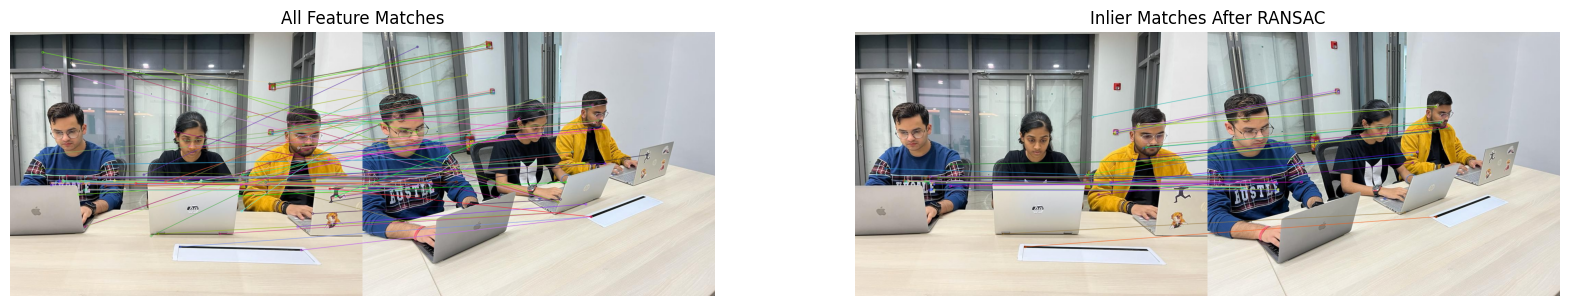

<ipython-input-11-e424c92d1f86>:77: RuntimeWarning: overflow encountered in divide
  pts3d = pts4d[:3] / pts4d[3]


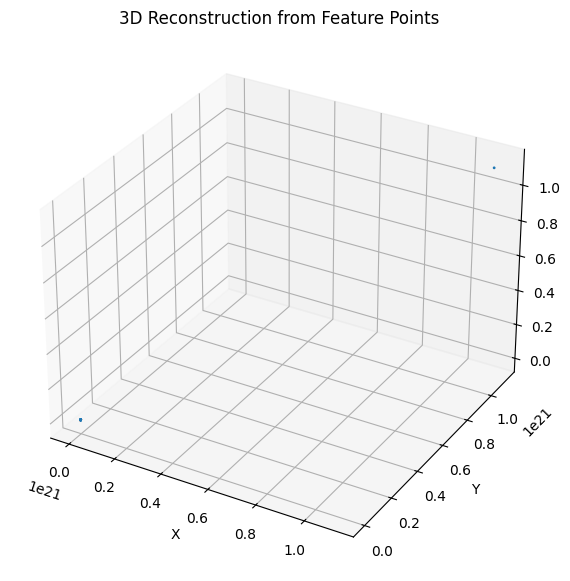

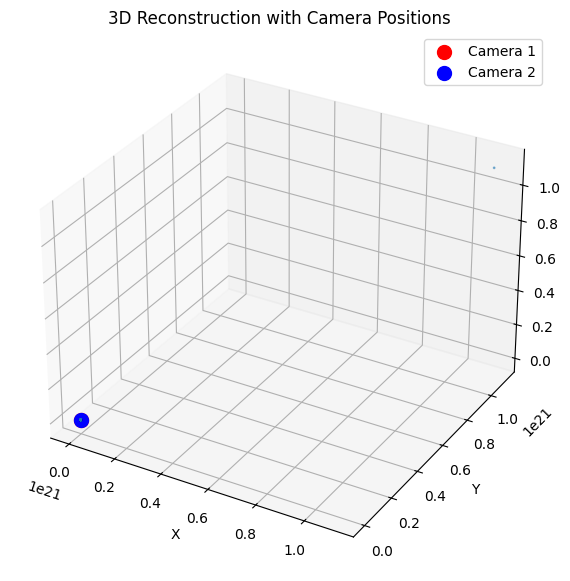

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load images
img1 = cv2.imread('perspective1.jpeg', 0)
img2 = cv2.imread('perspective2.jpeg', 0)

# Create color versions for display
img1_color = cv2.cvtColor(cv2.imread('perspective1.jpeg'), cv2.COLOR_BGR2RGB)
img2_color = cv2.cvtColor(cv2.imread('perspective2.jpeg'), cv2.COLOR_BGR2RGB)

# Feature detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Draw matches
img_matches = cv2.drawMatches(img1_color, kp1, img2_color, kp2, good, None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Find fundamental matrix
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Draw inlier matches
img_inlier_matches = cv2.drawMatches(img1_color, kp1, img2_color, kp2,
                                   [good[i] for i in range(len(good)) if mask.ravel()[i]==1],
                                   None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display original images and matches
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_matches)
plt.title('All Feature Matches')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_inlier_matches)
plt.title('Inlier Matches After RANSAC')
plt.axis('off')
plt.show()

# Camera intrinsics (you'll need to calibrate your camera or make reasonable assumptions)
K = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])

# Essential matrix
E = K.T @ F @ K

# Recover pose
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

# Triangulate points
proj1 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
proj2 = np.hstack((R, t))
proj1 = K @ proj1
proj2 = K @ proj2

pts4d = cv2.triangulatePoints(proj1, proj2, pts1.T, pts2.T)
pts3d = pts4d[:3] / pts4d[3]

# Visualize 3D points
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[0], pts3d[1], pts3d[2], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Reconstruction from Feature Points')
plt.show()

# Display camera positions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[0], pts3d[1], pts3d[2], s=1, alpha=0.5)

# Draw camera positions and orientations
camera1_pos = np.array([0, 0, 0])
camera2_pos = -R.T @ t.ravel()

ax.scatter(camera1_pos[0], camera1_pos[1], camera1_pos[2], c='r', s=100, label='Camera 1')
ax.scatter(camera2_pos[0], camera2_pos[1], camera2_pos[2], c='b', s=100, label='Camera 2')

# Draw camera frustums (simplified)
def draw_camera(ax, pos, R, color, length=0.5):
    # Camera axes
    axes = np.eye(3) @ R.T
    for i in range(3):
        ax.quiver(pos[0], pos[1], pos[2],
                 axes[0,i], axes[1,i], axes[2,i],
                 length=length, color=color, arrow_length_ratio=0.1)

    # Simple frustum
    corners = np.array([[0,0,1], [1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1]])
    corners = corners * length
    corners = corners @ R.T + pos
    ax.plot([pos[0], corners[0,0]], [pos[1], corners[0,1]], [pos[2], corners[0,2]], color+'--')
    for i in range(1,5):
        ax.plot([pos[0], corners[i,0]], [pos[1], corners[i,1]], [pos[2], corners[i,2]], color+'--')
        ax.plot([corners[i,0], corners[i%4+1,0]], [corners[i,1], corners[i%4+1,1]],
                [corners[i,2], corners[i%4+1,2]], color+'-')

draw_camera(ax, camera1_pos, np.eye(3), 'r')
draw_camera(ax, camera2_pos, R, 'b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Reconstruction with Camera Positions')
plt.show()

#**Task 2**

###**1. Image Restoration with Autoencoder (MNIST)**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.2423 - val_loss: 0.1184
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1166 - val_loss: 0.1088
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1087 - val_loss: 0.1053
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1057 - val_loss: 0.1030
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1035 - val_loss: 0.1015
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1019 - val_loss: 0.1004
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1009 - val_loss: 0.0994
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1001 - val_loss: 0.0986
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0993 - val_loss: 0.0985
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0986 - val_loss: 0.0978
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0980 - val_loss: 0.0972

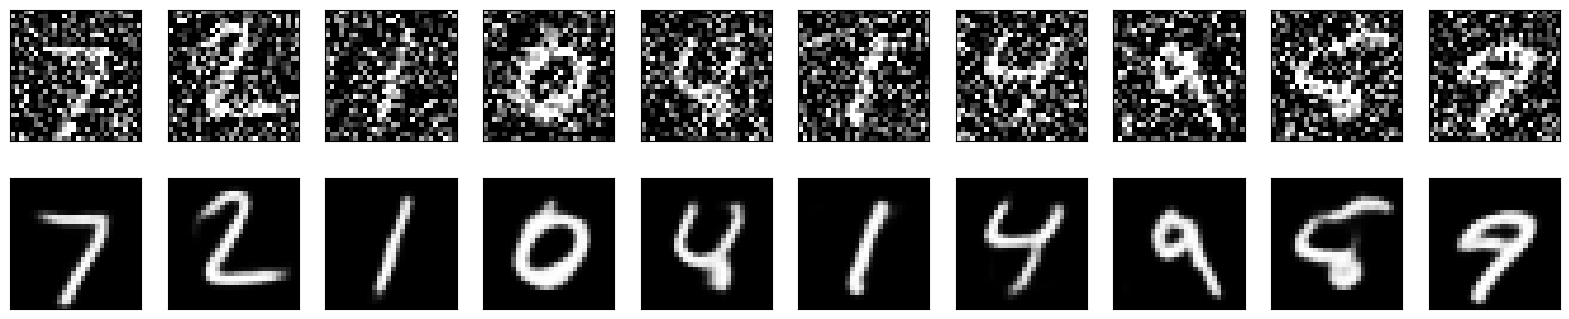

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip to valid range
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Autoencoder model
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Predict
denoised_images = autoencoder.predict(x_test_noisy)

# Display
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(denoised_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

###**2. GAN Implementation (MNIST and CIFAR-10)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
img_shape = (1, 28, 28)  # MNIST images are 1x28x28
batch_size = 64
epochs = 100
lr = 0.0002
b1 = 0.5  # beta1 for Adam optimizer
b2 = 0.999

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Configure data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

# Training
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Print progress
        if i % 200 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Save generated images every epoch
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            gen_imgs = generator(z).cpu().numpy()

        fig, axs = plt.subplots(4, 4, figsize=(4, 4))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i,j].imshow(gen_imgs[cnt, 0, :,:], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.savefig(f"mnist_epoch_{epoch}.png")
        plt.close()

# Save models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

[Epoch 0/100] [Batch 0/938] [D loss: 0.7061] [G loss: 0.6774]
[Epoch 0/100] [Batch 200/938] [D loss: 0.5588] [G loss: 0.9139]
[Epoch 0/100] [Batch 400/938] [D loss: 0.5090] [G loss: 0.7248]
[Epoch 0/100] [Batch 600/938] [D loss: 0.4250] [G loss: 1.1107]
[Epoch 0/100] [Batch 800/938] [D loss: 0.3765] [G loss: 0.9480]
[Epoch 1/100] [Batch 0/938] [D loss: 0.4195] [G loss: 0.8201]
[Epoch 1/100] [Batch 200/938] [D loss: 0.5120] [G loss: 0.7091]
[Epoch 1/100] [Batch 400/938] [D loss: 0.3881] [G loss: 1.8523]
[Epoch 1/100] [Batch 600/938] [D loss: 0.5853] [G loss: 1.9568]
[Epoch 1/100] [Batch 800/938] [D loss: 0.4074] [G loss: 2.5797]
[Epoch 2/100] [Batch 0/938] [D loss: 0.3414] [G loss: 1.5260]
[Epoch 2/100] [Batch 200/938] [D loss: 0.2866] [G loss: 1.4090]
[Epoch 2/100] [Batch 400/938] [D loss: 0.1417] [G loss: 2.0201]
[Epoch 2/100] [Batch 600/938] [D loss: 0.3072] [G loss: 3.0863]
[Epoch 2/100] [Batch 800/938] [D loss: 0.2632] [G loss: 3.6275]
[Epoch 3/100] [Batch 0/938] [D loss: 0.3166] [

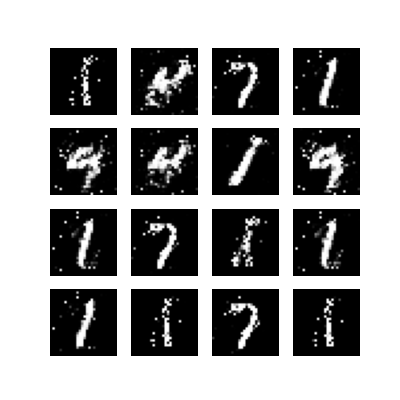

In [ ]:
from IPython.display import Image, display

display(Image(filename="/content/mnist_epoch_90.png"))

Epoch 1/50: 100%|██████████| 782/782 [00:42<00:00, 18.30it/s, D_loss=0.705, G_loss=0.824]


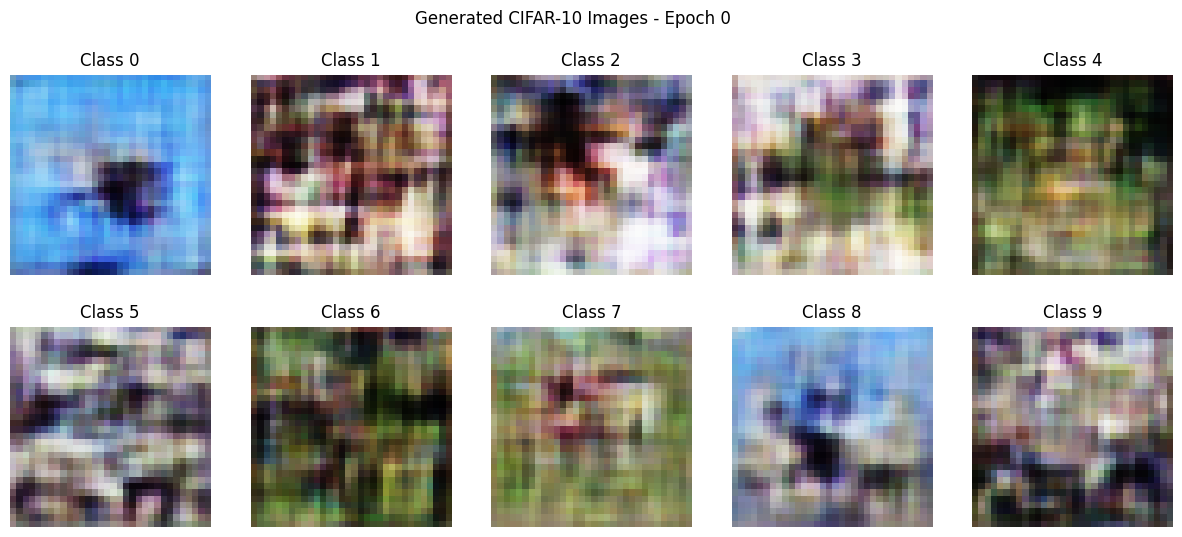

Epoch 11/50: 100%|██████████| 782/782 [00:43<00:00, 18.07it/s, D_loss=0.65, G_loss=2.44]


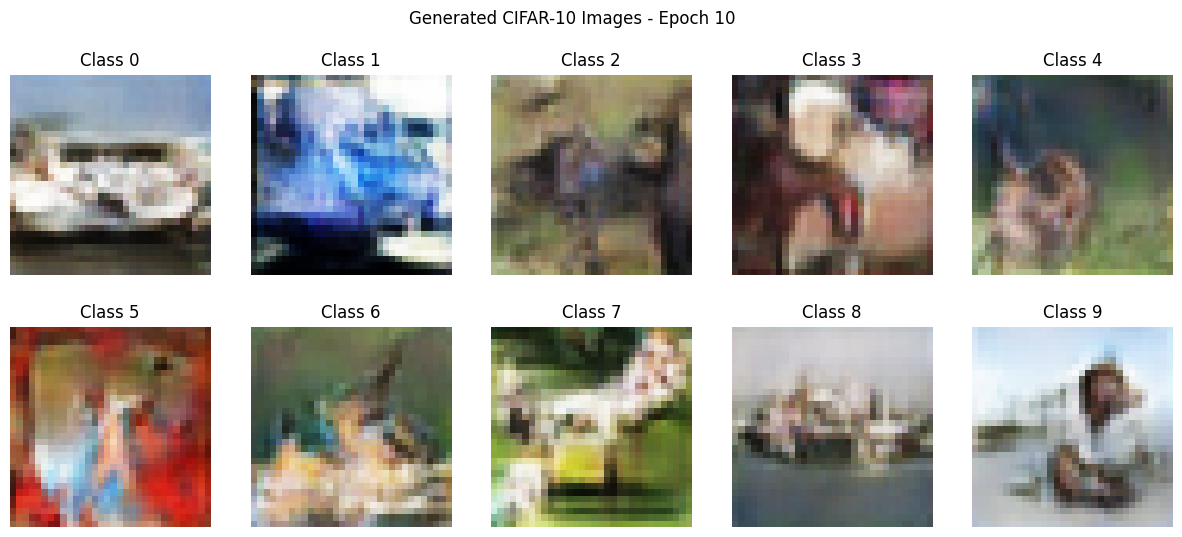

Epoch 21/50: 100%|██████████| 782/782 [00:43<00:00, 17.80it/s, D_loss=0.344, G_loss=3.7]


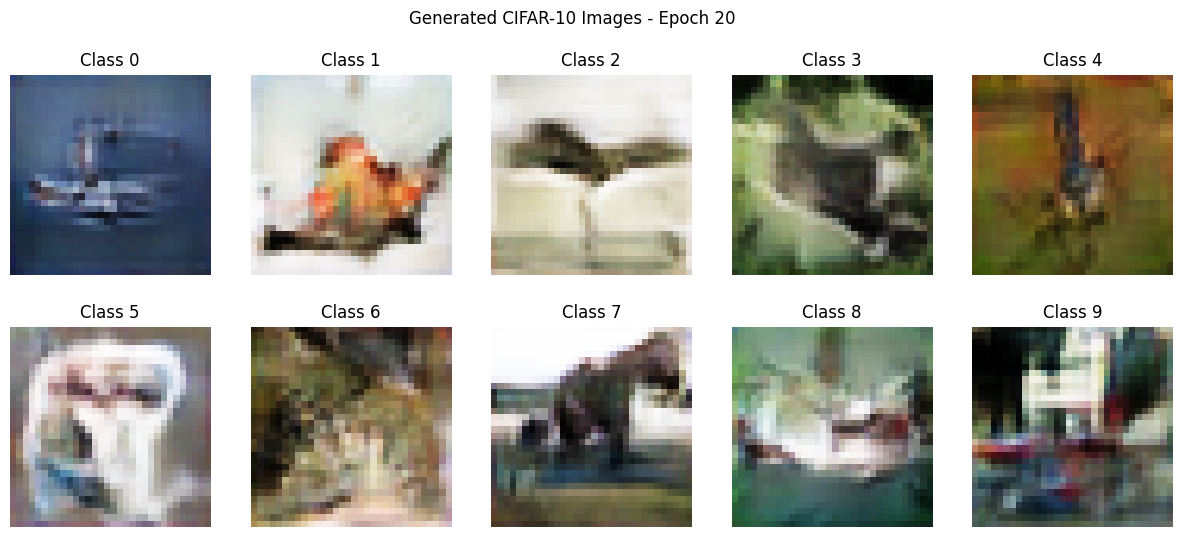

Epoch 31/50: 100%|██████████| 782/782 [00:44<00:00, 17.72it/s, D_loss=0.148, G_loss=4.78]


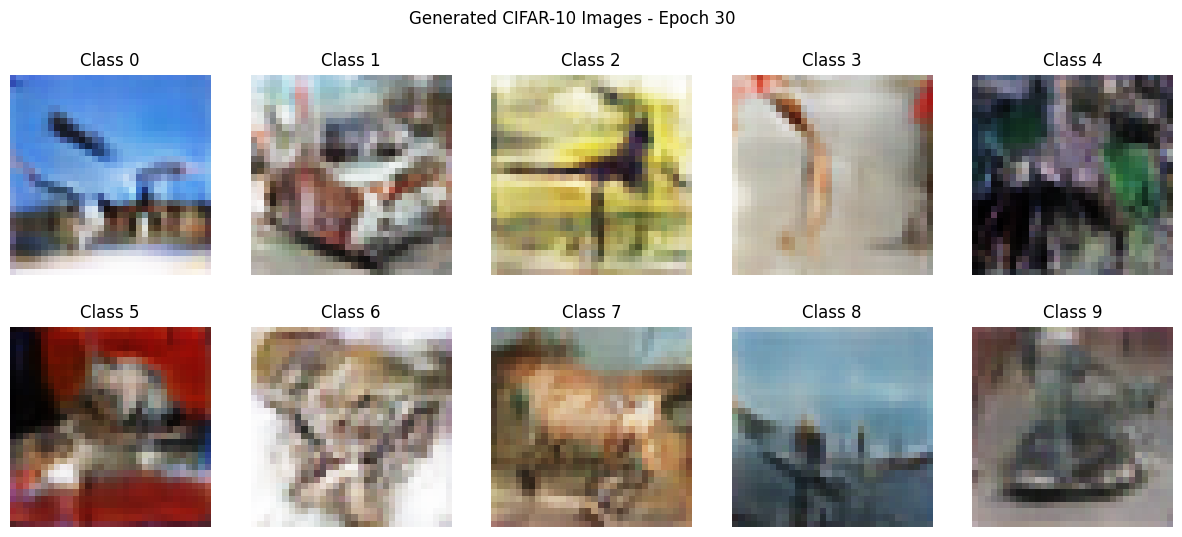

Epoch 41/50: 100%|██████████| 782/782 [00:44<00:00, 17.44it/s, D_loss=0.129, G_loss=5.21]


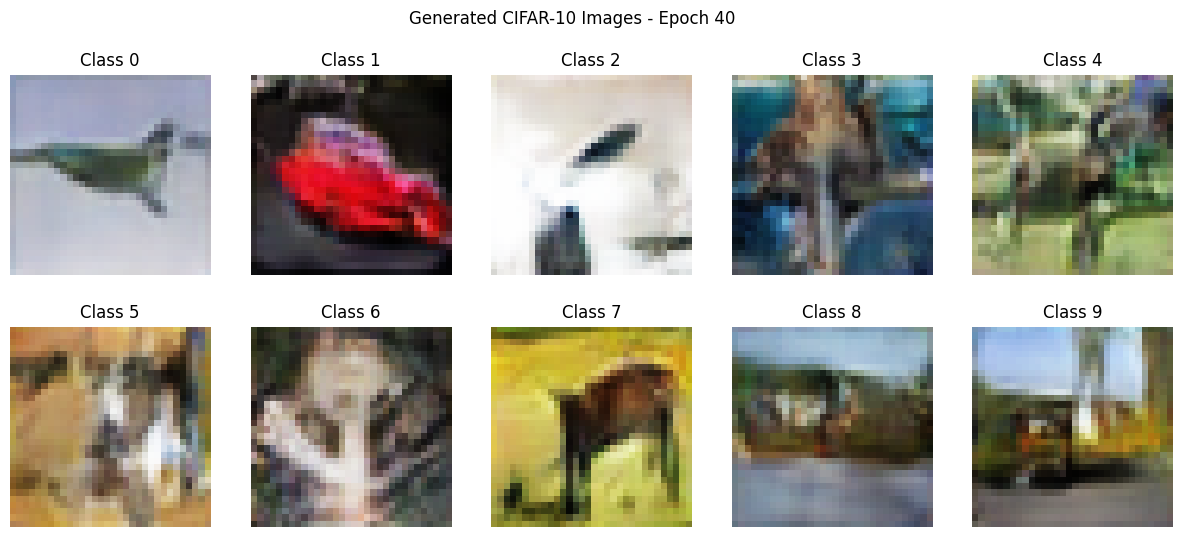

Epoch 50/50: 100%|██████████| 782/782 [00:44<00:00, 17.45it/s, D_loss=0.278, G_loss=9.28]


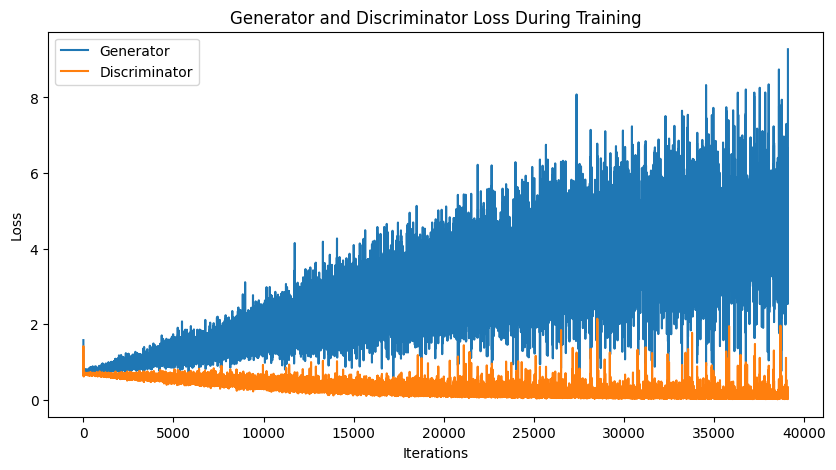

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
num_classes = 10  # CIFAR-10 has 10 classes
img_size = 32
channels = 3
batch_size = 64
epochs = 50
lr = 0.0002
b1 = 0.5
b2 = 0.999

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Label embedding - outputs 1 channel to match with RGB (3) + 1 = 4 channels
        self.label_embedding = nn.Embedding(num_classes, 1)

        # Input channels: 3 (RGB) + 1 (label channel) = 4
        self.main = nn.Sequential(
            # Input: 4 x 32 x 32
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 64 x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 128 x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 256 x 4 x 4
            nn.Conv2d(256, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: 1 x 1 x 1
            nn.Conv2d(512, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed labels and reshape to match image dimensions
        label_emb = self.label_embedding(labels)  # [batch_size, 1]
        label_emb = label_emb.view(-1, 1, 1, 1)  # [batch_size, 1, 1, 1]
        label_emb = label_emb.expand(-1, 1, img.size(2), img.size(3))  # [batch_size, 1, 32, 32]

        # Concatenate image and label
        x = torch.cat((img, label_emb), dim=1)  # [batch_size, 4, 32, 32]

        # Forward through main network
        validity = self.main(x)
        return validity.view(-1, 1)  # Flatten output

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Configure data loader
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

# For plotting losses
G_losses = []
D_losses = []

# Training
for epoch in range(epochs):
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
    for i, (imgs, labels) in enumerate(progress_bar):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)

        # Loss for fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        progress_bar.set_postfix({'D_loss': d_loss.item(), 'G_loss': g_loss.item()})

    # Generate and save sample images at the end of each epoch
    if epoch % 10 == 0:
        with torch.no_grad():
            # Generate one sample per class
            z = torch.randn(num_classes, latent_dim, device=device)
            labels = torch.arange(num_classes, device=device)
            gen_imgs = generator(z, labels).cpu().numpy()

            # Rescale images to 0-1
            gen_imgs = 0.5 * gen_imgs + 0.5

            # Plot
            fig, axs = plt.subplots(2, 5, figsize=(15, 6))
            fig.suptitle(f'Generated CIFAR-10 Images - Epoch {epoch}')
            for i in range(num_classes):
                row = i // 5
                col = i % 5
                axs[row, col].imshow(np.transpose(gen_imgs[i], (1, 2, 0)))
                axs[row, col].set_title(f'Class {i}')
                axs[row, col].axis('off')
            plt.show()

# Plot training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()